# Example Notebook: Using `fair-lnc-evaluation` on standard ML datasets

This notebook demonstrates the usage of `fair-lnc-evaluation` to empirically evaluate the **Polishing Labels** noise correction method (Nicholson, Bryce, et al. "Label noise correction methods." 2015 IEEE International Conference on Data Science and Advanced Analytics (DSAA). IEEE, 2015.) on the *PhishingWebsites* dataset (https://www.openml.org/search?type=data&status=active&id=4534).

## Setup

First, import the necessary libraries.

The data should be loaded to a `Dataset` object. Some OpenML datasets can be loaded using the `get_data` method.

The considered label noise correction method needs to be a derived class from base class `LabelCorrectionModel`, from the `label-noise-correction` package (https://pypi.org/project/label-noise-correction/).

In [7]:
from fair_lnc_evaluation.empirical_evaluation import EmpiricalEvaluation
from fair_lnc_evaluation.classifier import Classifier
from fair_lnc_evaluation.data import get_data

from label_noise_correction.pl import PolishingLabels
from sklearn.linear_model import LogisticRegression
import mlflow
import matplotlib.pyplot as plt

In [2]:
# Load data

dataset = get_data('phishing', 'having_IP_Address')

# Initialize label noise correction method

lnc = PolishingLabels(LogisticRegression, n_folds=10)

## Running an experiment

To evaluate the considered label noise correction method on a dataset, initialize an `EmpiricalEvaluation` object and call its `start_experiment` method, which will run the necessary experiments according to the proposed methodology and save the results to MLflow.

Here, as we want to use a standard ML dataset, which is assumed to have clean labels, we set the `noise_injection` parameter to `True` and the `noise_type` to "bias" so that the labels are manipulated to simulate this type of noise at increasing rates.

In [3]:
evaluation = EmpiricalEvaluation(dataset, lnc)

evaluation.start_experiment(True, 
                            Classifier(LogisticRegression(), 'LogReg'), 
                            noise_type='bias', 
                            metrics=['roc_auc', 'predictive_equality_difference'], 
                            classification_thresholds=[0.5])

2023/06/12 17:54:43 INFO mlflow.tracking.fluent: Experiment with name 'phishing_having_IP_Address_PL_bias' does not exist. Creating a new experiment.


Starting experiment: phishing_having_IP_Address_PL_bias
Injecting bias noise at rates: [0.1, 0.2, 0.3, 0.4, 0.5]


  0%|          | 0/5 [00:00<?, ?it/s]

## Analyze Results

Next, we will retrieve the run data from MLflow.


In [4]:
results = mlflow.search_runs(experiment_names=['phishing_having_IP_Address_PL_bias'], order_by=['start_time DESC'])

### Original test set

Finally, let's analyze the experiment results by accessing the stored metrics and parameters. 

Here, we analyze how the **Polishing Labels** method performed on a noise-free testing scenario (i.e., the *original* test set), comparing its performance to the performance of using the *original* train set (assumed to be noise-free) and the *noisy* train sets, which were manipulated for the experiments.


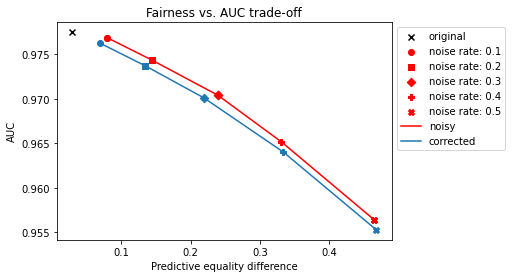

In [26]:
colors = {'original': 'black', 'noisy': 'red', 'corrected': 'tab:blue'}
markers = {0.1: 'o', 0.2: 's', 0.3: 'D', 0.4: 'P', 0.5: 'X'}

plt.scatter(results.loc[(results['tags.test_set'] == 'original') & (results['tags.train_set'] == 'original')]['metrics.predictive_equality_difference_0.5'].values[0],
            results.loc[(results['tags.test_set'] == 'original') & (results['tags.train_set'] == 'original')]['metrics.roc_auc'].values[0],
            color=colors['original'], marker='x', label='original')

for train_set in ['noisy', 'corrected']:
    values = results.loc[(results['tags.test_set'] == 'original') & (results['tags.train_set'] == train_set)].sort_values(['params.noise_rate'])
    auc = values['metrics.roc_auc'].values
    fairness = values['metrics.predictive_equality_difference_0.5'].values

    for i in range(5):
        if train_set == 'noisy':
            plt.scatter(fairness[i], auc[i], color=colors[train_set], marker=markers[(i+1)/10], label=f'noise rate: {(i+1)/10}')
        plt.scatter(fairness[i], auc[i], color=colors[train_set], marker=markers[(i+1)/10])
    plt.plot(fairness, auc, label=train_set, color=colors[train_set])

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Predictive equality difference')
plt.ylabel('AUC')
plt.title('Fairness vs. AUC trade-off')
plt.show()